#### What are decision trees
Decision trees is a family of non-parametric (meaning that there's no finite space of parameters) supervised ML algorithms that is **spread in fintech** thanks to their better interpretability and good ability to work with relatively non-sparse data. Decision trees can be **used** both **in** **regression** and **classification** problems.

A variety of Decision Tree algorithms include:
* CHAID
* CART
* ID3
* C4.5

This **notebook will be devoted to** implementing CART (Classification and Regression Tree) algortihm in particular. 

**Advantages** of CART are considered to be the following:
* Most interpertable amongst other models with a possibility for creating an intuitive visualisation
* Minimal data preparation is required

Primary **disadvanatages** CART are:
* Overfit on datasets with high variance
* Decision trees use heuristic approach (learning by trial and error), that cannot guarantee an optimal solution


#### Assumptions before choosing CART
There is a number of aspects to CART algorithm that need to be taken into account despite their non-parametric nature:
* **NaN** values should be **accounted for**
* CART is generally a **bad choice** for datasets with **high number of features**, as this algorithm tends to overfit in these cases. In these cases we can use dimensionality redunction techniques like PCA (Principal Component Analysis)
* Values **should be normalised** to avoid high variance in data, where this variance can lead to overfit as well

#### What are CART Trees are comprised of 
Decision trees are comprised of a set of connected nodes with each containing some binary decision that defines how data will be split. Incoming data is "flowing" through nodes until it reaches a terminal node, where it can no longer be split. There are three different types of nodes, that can be seen in a toy diagram below:
* Root node: node that has no parent and that contains the intial decision rule (blue)
* Interior nodes: nodes that are created with splits (yellow)
* Leaf nodes: terminal nodes (green)

<p align="center"> <img src="./media/tree_diagram.png" alt="dot product"/> </p>

#### Metrics to quantify tree's split quality
Metrics for classification trees and regression trees differ from each other, which we improve on each iteration.

For **classification metrics** one of the most popular are the following:
* Gini impurity 
* Shanon entropy

For **regression metrics** we can use trivial metrics like:
* MSE
* MAE

#### Classification metrics: Gini impurity or Gini index (GI)
##### Formulas:
* $Error_c=f_c\times(1-f_c)$, where f_c - fraction of items classified as $c$ on particular node
* $GI=\sum_cError_c=1-\sum_cf_c^2\in[0;1]$
##### Intuition:
This metric can measure the missclassification rate. Since every even is binary outcome on each node follows Bernoulli distribution. Therefore, this metric is basically a variance for an outcome on each node. We can then sum all variances since we make an assumption about about independence of nodes.

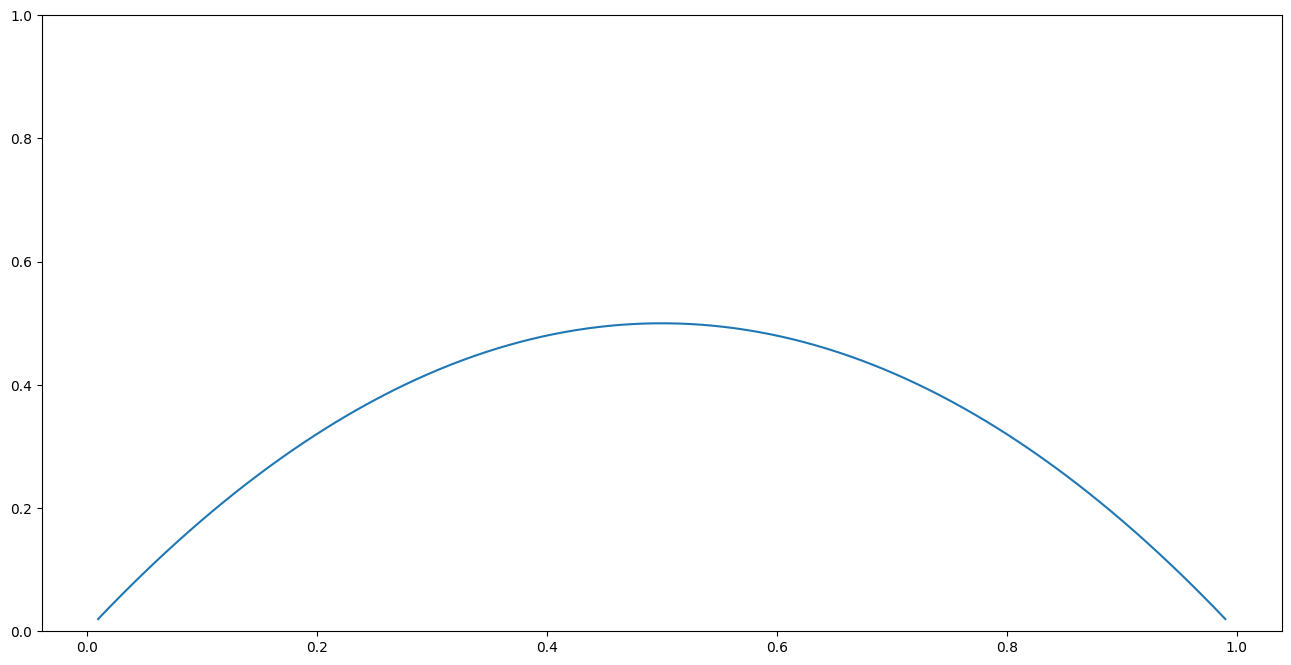

In [4]:
# example of Gini Index of two outcomes (e.g. coin flip),
# i.e. two distinct classes

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

p = np.linspace(0.01,0.99,100)
plt.figure(figsize=(16,8))
plt.plot(p,2*p*(1-p))
plt.ylim(0,1)
plt.show()

#### Classification metrics: Shannon Entropy
##### Formulas:
* $Entropy=-\sum_cf_c\times log_2(f_c)$, where f_c - fraction of items classified as $c$ on particular node
##### Intuition:
Domain of $log_2(f_c)$ is $[-\infty; 0]$ (because of $f_c\in[0, 1]$), therefore we apply "-" sign to the sum, to make it more interpretable, i.e. the less is the entropy, the better is the purity. It is almost the same as the Gini Index, but here we take the product of all possible outcomes and then take the $log_2$ of both parts, converting it to a more easily differentiable sum of variables. The base $2$ does not play a significant role, but is considered a better option of computer-based calculations.
##### Example:
Let's consider the same coinflip example, but we will use entropy to measure "coin's impurity":


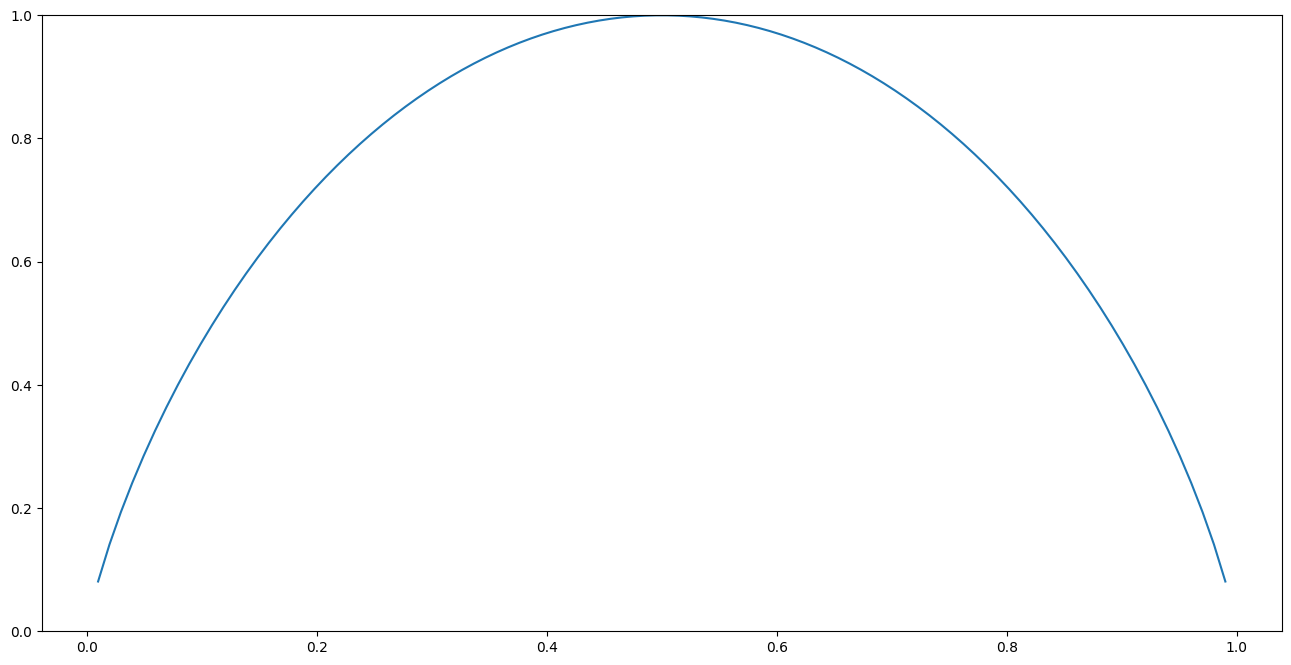

In [5]:
plt.figure(figsize=(16,8))
plt.plot(p,-p*np.log2(p)-(1-p)*np.log2(1-p))
plt.ylim(0,1)
plt.show()

#### Regression metrics: MSE
##### Formulas:
$MSE=\frac{1}{N_{nodes}}\sum_i^{N_{nodes}}(y_i-\bar{y})^2$
##### Intuition:
In this case MSE plays a role of variance, where $0$ is the best estimate.

#### How to apply metrics to optimisation
The metric that is optimized in all problems, both regression and classification, is **information gain (IG)**. **The higher** is the **IG**, the **better** is the split. 

Information gain can also tell us **how important** a given feature is and, therefore, decide the **ordering of attributes** in the nodes of a decision tree to split it in the most efficient way possible. Steps for calculating $IG$ are the following:
- First we calculate weighted metric amongst tree's children on every split: $\sum_{node}metric_{node}\times\frac{d}{n}$, where:
    - $metric$: a metric chosen for specific task (entropy, MSE, e.t.c.). We then calculate this metric on each node that we got from the split
    - $d$: number of records in particular node that we got from the split
    - $n$: number of records in the parent node that we split
- Then we calculate an actual information gain  $IG=metric(parent) - metric_{weighted}$, where:
    - $metric(parent)$ is a metric calculated on records inside the parent node
    - $metric_{weighted}$ is a calculated weighted metric from the previous step

Here is the visualisation that sums up this logic in a clear and concise way:
<p align="center"> <img src="./media/info_gain.png" alt="dot product"/> </p>


#### Rewriting metrics as callable functions

In [6]:
import numpy as np
import pandas as pd

def gini(y):
    if y.size == 0: return 0
    p = np.unique(y, return_counts=True)[1] / len(y)
    return (p*(1-p)).sum()

def shannon(y):
    if y.size == 0: return 0
    p = np.unique(y, return_counts=True)[1] / len(y)
    eps = 1e-10
    return (p*np.log2(p+eps)).sum()

def variance(y):
    if y.size == 0: return 0
    return y.var()

#### Parameters of Decision Trees
Parameters that are commonly used in CART for post-prunin, i.e. removing unwanted splits to avoid overfitting, include:
- **max_depth**: maximum numer of levels to be allowed while growing the tree
- **min_samples_split**: $2$ by default, this parameter defines the minimum number of records inside a node required to split a node
- **min_impurity_decrease**: if weighted IG ($IG_{weighted}=IG\times\frac{N_{parent node}}{N}$) is greater or equal to this value than we consider splitting the node, otherwise we don't. It allows us to capture features that are the most influential and induce the highest IG possible
- and other, less known, parameters

#### Implementation
##### Data
For classification problem **iris** dataset is going to be used, and for regression problem - **diabetes**

In [7]:
from sklearn.datasets import load_iris, load_diabetes
iris = load_iris()
diabetes = load_diabetes()

In [8]:
# converting diabetes dataset (regression) to 
# dataframe

import pandas as pd
import numpy as np

dX = diabetes['data']
dY = diabetes['target']
dDF = pd.DataFrame(
    data = np.hstack((dX,dY.reshape(dX.shape[0],1))),\
    columns=np.append(diabetes['feature_names'],'target'))
dDF.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [9]:
# converting iris dataset (classification) to 
# dataframe

import pandas as pd
import numpy as np

irisX = iris['data']
irisY = iris['target']
irisDF = pd.DataFrame(
    data = np.hstack([irisX,irisY.reshape(irisX.shape[0],1)]),\
    columns=np.append(iris['feature_names'],'target'))
irisDF.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


#### Information gain
To quantify split's quality we need to implement IG function. 

In [23]:
def ig(parent, mask, metric):
    """
        mask - true/false array, which displays to wich node different points went (true - left, false - right)
        y - array of true values (or classes)
        metric - gini, entropy or variance in our case
    """
    node1 = mask.sum() # number of points on the left node
    node2 = mask.size - node1 # points on the right node
    N = mask.size

    # if there is no way to split data into two more nodes, that
    # means that there is no more room for improvement and the IG is
    # going to be 0
    if (node1 == 0 or node2 == 0): return 0

    return metric(parent) - (metric(parent[mask]) * node1 / N + metric(parent[~mask]) * node2 / N)

We can also try to calculate IG from the root node, on the first split. We'll select random feature from each of two previous datasets and assign threshholds to them and calculate how good the split:

In [26]:
# select petal length and calculate information gain based on condition "petal length < 3.5"
# and gini index
ig(
    irisDF['target'].values,
    (irisDF['petal length (cm)'] < 3.5).values,
    gini
)

0.30590676262724514

Same can be done with regression problems. We calculate the quality of the split by calculating information gain with variance included:

In [41]:
ig(
    dDF['target'].values,
    (dDF['age'] < .08).values,
    variance
)

5.23774513375065